<a href="https://colab.research.google.com/github/FarizKesten/DS_Challenge/blob/main/RealTimeIntrusionDetection_Duplicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks:
1. Training: Build a detection model that can detect footsteps and fence climbing given the provided data.
2. Inference: Implement a prototype that can read DAS data, run the detection model and output when
and where in the provided data footsteps resp. fence climbing occurs.
3. Visualize the output of the prototype in some way and evaluate the real-time capability of the prototype.
4. Given a few samples from a different installation, evaluate and (if necessary) adjust such that the
detection still works.

### importing all necessaries libraries

In [2]:
# Adding neccesary libraries
import os
import math
import time
import glob
import random
import numpy as np
import importlib.util
from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T
import albumentations as A
import torchvision.transforms.functional as F

import random

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [7]:
'''
PATH-ACCESS: PLEASE CHANGE THE PATH TO YOUR CURRENT PATH

For convenience I saved all the data from the E-Mail to my Drive,
however I keep it private so that no one from outside could retrieve it. I can give acces to the Drive if neccessary
Otherwise, pleas replace the location of the data to run the script
'''

base_path = '/content/drive/MyDrive/ds_challenge'
path_task1 = os.path.join(base_path, 'Task1') # Path for Task1 Folder
path_task2 = os.path.join(base_path, 'Task2') # Path for Task2 Folder
path_task4 = os.path.join(base_path, 'Task4') # Path for Task4 Folder
path_model = os.path.join(base_path, 'models_dup') # Path where the model is saved / located


In [8]:
def read_image(path):

  """
  reading image from the disk, filter them and return them
  """

  data = np.load(path)
  data = np.cumsum(data, axis=0, dtype=np.int64).astype(np.float32)
  # Convert to radians
  data *= np.pi / 2**15

  # most likely want to highpass filter now to reduce low frequency noise
  sos = signal.butter(2, 5, "high", fs=1000, output="sos")
  data = signal.sosfiltfilt(sos, data, axis=0)
  return np.ascontiguousarray(data)

# Viewing sample images to get better understanding

Viewing the 3 classes as well as inference to understand the current dataset

float64


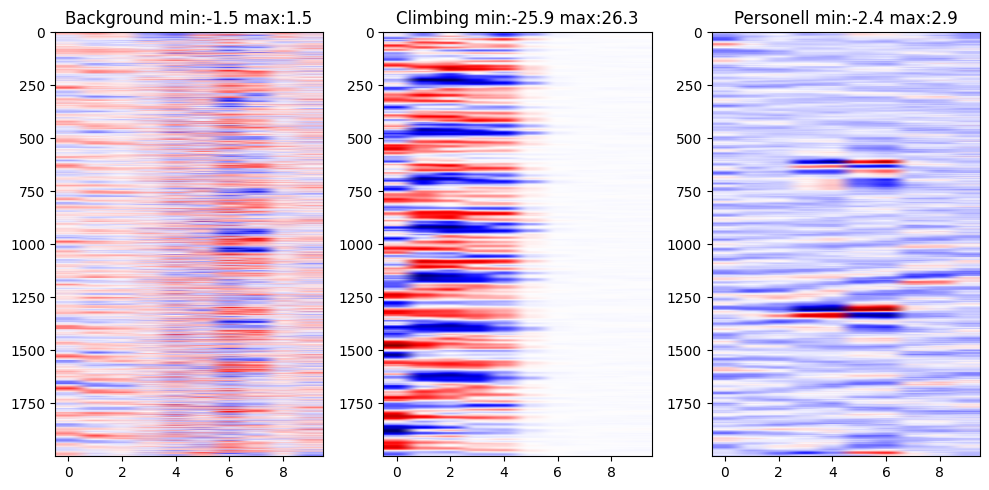

In [9]:
# find all training images

task = path_task1
#task = path_task4

# background
bgd_img = glob.glob(
    os.path.join(task, 'training', 'background', '**', '*.npy'),
    recursive=True
)

# climbing images
clm_img = glob.glob(
    os.path.join(task, 'training', 'climbing', '**', '*.npy'),
    recursive=True
)

# personnel
prs_img = glob.glob(
    os.path.join(task, 'training', 'personnel', '**', '*.npy'),
    recursive=True
)

# try to view 1 image of each class
idx = random.randint(0, min(len(bgd_img) - 1, len(clm_img) - 1, len(prs_img) - 1))
bgd = np.load(bgd_img[idx])
clm = np.load(clm_img[idx])
prs = np.load(prs_img[idx])

bgd = read_image(bgd_img[idx])
clm = read_image(clm_img[idx])
prs = read_image(prs_img[idx])

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

cmap = 'seismic'
#axes[0].imshow(bgd, cmap=cmap, aspect="auto" )
axes[0].imshow(bgd, cmap=cmap, aspect="auto" )
print(bgd.dtype,)
axes[0].set_title(f"Background min:{np.min(bgd):.1f} max:{np.max(bgd):.1f}")
#axes[0].axis('off')

axes[1].imshow(clm, cmap=cmap, aspect="auto")
axes[1].set_title(f"Climbing min:{np.min(clm):.1f} max:{np.max(clm):.1f}")
#axes[1].axis('off')

axes[2].imshow(prs, cmap=cmap, aspect="auto")
axes[2].set_title(f"Personell min:{np.min(prs):.1f} max:{np.max(prs):.1f}")
#axes[2].axis('off')

plt.tight_layout()
plt.show()



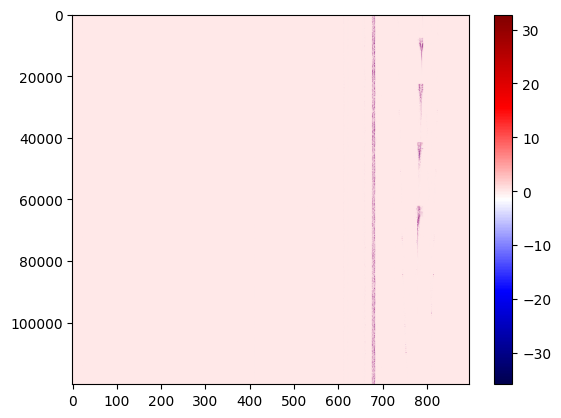

In [6]:
# view inference image

# inference
inf_img = glob.glob(
    os.path.join(path_task2, 'inference', '*.npy'),
    recursive=True
)

inference_image = read_image(inf_img[0])
plt.imshow(inference_image, cmap="seismic", aspect="auto")
plt.colorbar()
plt.show()


# Task 1 : Training

I see this as a segmentation task since we also need to localize the class in the image.

For rapid-prototyping of segmentation models I would use the segmentaiton-models-pytorch library

In [10]:
if importlib.util.find_spec('segmentation_models_pytorch') is None:
    !pip install -q segmentation-models-pytorch > /dev/null 2>&1

import segmentation_models_pytorch as smp


In [11]:
# CONSTANTS
BATCH_SIZE = 4
CLASS_ID = { "background" : 0, "climbing" : 1, "personnel" : 2}

### Preparing Dataset Pipeline


In [12]:

class SegmentationDataset(Dataset):
  """
  Setting up datasets for training, validation and testing
  """
  def __init__(self, image_path, class_id, transform=False):
    self.transform = transform
    self.class_id = class_id

    self.image_path = image_path

    # image augmentations
    if self.transform:
      frequency = 0.3
      self.aug_transform = A.Compose([
          A.HorizontalFlip(p=frequency),
          A.VerticalFlip(p=frequency),
          A.Rotate(limit=30, p=frequency),
      ], additional_targets={'mask': 'mask'})


  def __len__(self):
    return len(self.image_path)

  def trans(self, image, mask):
    '''
    add some randomness on the training dataset
    '''

    if random.random() > 0.5:
      image = F.hflip(image)
      mask = F.hflip(mask)

    if random.random() > 0.5:
      image = F.vflip(image)
      mask = F.vflip(mask)

    if random.random() > 0.5:
      angle = random.randint(-30, 30)
      image = F.rotate(image, angle)
      mask = F.rotate(mask, angle)

    return image, mask


  def __getitem__(self, index):
    '''
    get both images and create a mask filled with the class_id.
    Assumption: each image has a corresponding mask without
    background information
    '''

    #image = np.load(self.image_path[index])
    image = read_image(self.image_path[index])

    height, width = image.shape

    mask  = np.full((height, width), fill_value=self.class_id[index], dtype=np.int32)

    image_tensor = torch.from_numpy(image).unsqueeze(0)
    mask_tensor = torch.from_numpy(mask)


    if self.transform:
      image_pil = F.to_pil_image(image_tensor)
      mask_pil = F.to_pil_image(mask_tensor)
      image_pil, mask_pil  = self.trans(image_pil, mask_pil)
      image_tensor = T.ToTensor()(image_pil)
      mask_tensor = torch.from_numpy(np.array(mask_pil, dtype=np.int32)).long()

    # Determine padding needed (to make height & width divisible by 32)
    #(needed for example by U-Net)
    pad_h = (32 - height % 32) if height % 32 != 0 else 0
    pad_w = (32 - width % 32) if width % 32 != 0 else 0

    # Apply padding (PyTorch uses (left, right, top, bottom) format)
    padder = nn.ConstantPad2d((0, pad_w, 0, pad_h), 0)
    image_tensor = padder(image_tensor)
    mask_tensor = padder(mask_tensor)


    return image_tensor.float(), mask_tensor.long()


  """

  def __getitem__(self, index):
    '''
    TODO: Testing using Albumentations for augmentation. Currently not used
    due to time reason

    get both images and create a mask filled with the class_id.
    Assumption: each image has a corresponding mask without
    background information
    '''
    image = read_image(self.image_path[index])
    height, width = image.shape

    # generate mask. Current approach: fill the whole pixel with the class-id
    mask  = np.full((height, width),
                    fill_value=self.class_id[index],
                    dtype=np.int32
                    )

    # If augmentation is enabled, apply Albumentations.
    if self.transform:
        image_aug = image[..., np.newaxis]  # shape becomes [H, W, 1]
        augmented = self.aug_transform(image=image_aug, mask=mask)
        image_aug = augmented["image"]
        mask = augmented["mask"]
    else:
        image_aug = image[..., np.newaxis]

    image_tensor = torch.from_numpy(image_aug).permute(2, 0, 1)
    mask_tensor = torch.from_numpy(mask)

    # Determine padding needed (to make height & width divisible by 32)
    #(needed for example by U-Net)
    pad_h = (32 - height % 32) if height % 32 != 0 else 0
    pad_w = (32 - width % 32) if width % 32 != 0 else 0

    # Apply padding (PyTorch uses (left, right, top, bottom) format)
    padder = nn.ConstantPad2d((0, pad_w, 0, pad_h), 0)
    image_tensor = padder(image_tensor)
    mask_tensor = padder(mask_tensor)

    return image_tensor.float(), mask_tensor.long()

  """

def gather_class_paths(task_dir, split="training", class_name="background", class_id=0):
  '''
  gather all image paths for a given class
  '''
  search_pattern = os.path.join(task_dir, split, class_name, '**', '*.npy')
  image_paths = glob.glob(search_pattern, recursive=True)

  class_ids = [class_id] * len(image_paths)

  return image_paths, class_ids

################################################################################
# collect all training data
################################################################################
bg_path, bg_id = gather_class_paths(task_dir=path_task1, split="training",
                                    class_name="background",
                                    class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="training",
                                      class_name="personnel",
                                      class_id=CLASS_ID["personnel"])
clm_path, clm_id = gather_class_paths(task_dir=path_task1, split="training",
                                      class_name="climbing",
                                      class_id=CLASS_ID["climbing"]
                                      )

all_training_path = bg_path + prs_path + clm_path
all_training_id = bg_id + prs_id + clm_id



################################################################################
# collect all validation & test data (20% goes to test dataset)
################################################################################
bg_path, bg_id = gather_class_paths(task_dir=path_task1, split="validation",
                                    class_name="background",
                                    class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="validation",
                                      class_name="personnel",
                                      class_id=CLASS_ID["personnel"])
clm_path, clm_id = gather_class_paths(task_dir=path_task1, split="validation",
                                      class_name="climbing",
                                      class_id=CLASS_ID["climbing"])

all_val_paths = bg_path + prs_path + clm_path
all_val_ids = bg_id + prs_id + clm_id

all_paths = all_val_paths + all_training_path
all_ids = all_val_ids + all_training_id

train_paths, rest_paths, train_ids, test_ids = train_test_split(
    all_paths, all_ids, test_size=0.3, random_state=42,
    stratify=all_ids
)

val_paths, test_paths, val_ids, test_ids = train_test_split(
    rest_paths, test_ids, test_size=0.2, random_state=42,
    stratify=test_ids
)



train_dataset = SegmentationDataset(
    image_path=all_training_path,
    class_id=all_training_id,
    transform=True
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_dataset = SegmentationDataset(
    image_path=val_paths,
    class_id=val_ids,
    transform=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_dataset = SegmentationDataset(
    image_path=test_paths,
    class_id=test_ids,
    transform=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


print(f"Number of training dataset: {len(train_dataset)}")
print(f"Number of validation dataset: {len(val_dataset)}")
print(f"Number of test dataset: {len(test_dataset)}")


Number of training dataset: 2699
Number of validation dataset: 1072
Number of test dataset: 269


In [13]:
unique_values, counts1 = np.unique(val_ids, return_counts=True)
print("validation", dict(zip(unique_values, counts1)))

unique_values, counts2 = np.unique(test_ids, return_counts=True)
print("test", dict(zip(unique_values, counts2)))

unique_values, counts3 = np.unique(all_training_id, return_counts=True)
print("train", dict(zip(unique_values, counts3)))


print(counts1 + counts2 + counts3)




validation {0: 493, 1: 88, 2: 491}
test {0: 124, 1: 22, 2: 123}
train {0: 375, 1: 343, 2: 1981}
[ 992  453 2595]


### Choosing the Model for classification

Potentially multiple models can be use to train and test for its performance

In [14]:
##################################################################
# try out multiple model candidates
##################################################################

encoder_name = "resnet50"
encoder_weights = "imagenet"
in_channels=1
classes=3


models = {
  "PSPNet": {
      "model": smp.PSPNet(
          encoder_name=encoder_name,
          encoder_weights=encoder_weights,
          in_channels=in_channels,
          classes=classes
      ),
      "lr": 0.0001
    },

    # Lightweight and supposed to be fast
     "LinkNet": {
        "model" : smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        ),
        "lr" : 0.0001
    },
    # Lightweight and Fast
    "FPN": {
        "model" : smp.FPN(
          encoder_name=encoder_name,
          encoder_weights=encoder_weights,
          in_channels=in_channels,
          classes=classes
      ),
    "lr" : 0.0001
    },

    # Klassiker
    "Unet": {
        "model" :smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        ),
        "lr" : 0.0001
    },

}
# printing all models that are used
print("models under tests: \n")
for key, model in models.items():
  print(key)

models under tests: 

PSPNet
LinkNet
FPN
Unet


### Add some training functions


In [15]:
##################################################################
# Training funcs
##################################################################

def train_one_epoch(model, loader, optimizer, criterion, device):
  '''
  train one epoch
  '''
  model.train()
  running_loss = 0.0

  for images, masks in loader:
    images = images.to(device)
    masks = masks.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, masks)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(loader)


def evaluate(model, loader, criterion, device):
  '''
  evaluate the model for validation
  '''
  model.eval()
  running_loss = 0.0

  with torch.no_grad():
    for images, masks in loader:
      images = images.to(device)
      masks = masks.to(device)

      outputs = model(images)
      loss = criterion(outputs, masks)

      running_loss += loss.item()

  return running_loss / len(loader)


def eval_multi_class(pred, target, num_classes, threshold=0.5):
  '''
  evaluate the model using multi-class metrics

  pred: the model prediction
  target: ground truth
  num_classes: number of classes
  threshold: threshold for the prediction
  '''
  # Convert logits to predicted class indices
  pred = torch.argmax(pred, dim=1)

  iou_per_class = []
  precision_per_class = []
  recall_per_class = []

  for class_idx in range(num_classes):
      pred_class = (pred == class_idx).float()
      target_class = (target == class_idx).float()

      intersection = (pred_class * target_class).sum().item()
      union = (pred_class + target_class).sum().item() - intersection

      # Compute IOU, avoid division by zero
      iou = intersection / (union + 1e-6)
      iou_per_class.append(iou)

      # Compute Precision & Recall
      tp = intersection
      fp = pred_class.sum().item() - tp
      fn = target_class.sum().item() - tp

      precision = (tp + 1e-6) / (tp + fp + 1e-6)
      recall = (tp + 1e-6) / (tp + fn + 1e-6)

      precision_per_class.append(precision)
      recall_per_class.append(recall)

  return {
      "IOU": sum(iou_per_class) / num_classes,
      "Precision": sum(precision_per_class) / num_classes,
      "Recall": sum(recall_per_class) / num_classes,
      "Class-wise IOU": iou_per_class,
      "Class-wise Precision": precision_per_class,
      "Class-wise Recall": recall_per_class
  }

### Function for evaluating multi-class models, will be used to select the better models

In [16]:
def eval_multi_class(pred, target, num_classes, threshold=0.5):
    """
    Evaluate the model using multi-class metrics.

    pred: the model prediction (logits or probabilities)
    target: ground truth (class indices)
    num_classes: number of classes
    threshold: threshold for the prediction (unused when using argmax)
    """
    # Convert logits/probabilities to predicted class indices
    pred = torch.argmax(pred, dim=1)

    iou_per_class = []
    precision_per_class = []
    recall_per_class = []

    for class_idx in range(num_classes):
        # Create binary masks for the current class.
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()

        # Compute intersection and union for IoU.
        intersection = (pred_class * target_class).sum().item()
        union = pred_class.sum().item() + target_class.sum().item() - intersection

        # Safely compute IoU.
        if union == 0:
            iou = 1.0  # If there is no ground truth or prediction, consider it a perfect match.
        else:
            iou = intersection / union
        iou_per_class.append(iou)

        # Compute true positives, false positives, and false negatives.
        tp = intersection
        fp = pred_class.sum().item() - tp
        fn = target_class.sum().item() - tp

        # Compute Precision.
        if (tp + fp) == 0:
            precision = 1.0  # Define as perfect if no predictions were made.
        else:
            precision = tp / (tp + fp)

        # Compute Recall.
        if (tp + fn) == 0:
            recall = 1.0  # Define as perfect if there are no ground truth positives.
        else:
            recall = tp / (tp + fn)

        precision_per_class.append(precision)
        recall_per_class.append(recall)

    # Average metrics across classes.
    metrics = {
        "IOU": sum(iou_per_class) / num_classes,
        "Precision": sum(precision_per_class) / num_classes,
        "Recall": sum(recall_per_class) / num_classes,
        "Class-wise IOU": iou_per_class,
        "Class-wise Precision": precision_per_class,
        "Class-wise Recall": recall_per_class,
    }
    return metrics


### Finally start training

In [17]:
# Start Training

NUM_EPOCHS = 200

# Use CrossEntropyLoss for multi-class classification
criterion = torch.nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

loss_history = {}
for key, cfg in models.items():
  model = cfg["model"]

  # Define optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=1e-4)
  # allow lr to change if model is not improving
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      factor=0.5,
      patience=5,
      verbose=True
  )

  best_val_loss = float('inf')
  train_loss_history = []
  val_loss_history = []

  # Define model saving directory
  model_dir = os.path.join(path_model, "models", key)
  os.makedirs(model_dir, exist_ok=True)

  # Move model to GPU/CPU
  model.to(device)

  early_stopping_patience = 10  # Number of epochs to wait for improvement
  epochs_without_improvement = 0
  for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    # Train and evaluate the model
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss) # adapt lr based on changes in the val_loss

    epoch_time = time.time() - start_time

    # Record losses for plotting
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
        print(f"New best model {key} saved at epoch {epoch+1}, Val Loss: {val_loss:.4f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Duration: {epoch_time:.2f} sec, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

  loss_history[key] = {"train": train_loss_history, "val": val_loss_history}



Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model PSPNet saved at epoch 1, Val Loss: 0.2407
Epoch 1/200 - Duration: 180.48 sec, Train Loss: 0.1609, Val Loss: 0.2407
New best model PSPNet saved at epoch 2, Val Loss: 0.1960
Epoch 2/200 - Duration: 15.17 sec, Train Loss: 0.1279, Val Loss: 0.1960
New best model PSPNet saved at epoch 3, Val Loss: 0.1729
Epoch 3/200 - Duration: 16.06 sec, Train Loss: 0.1193, Val Loss: 0.1729
New best model PSPNet saved at epoch 4, Val Loss: 0.1448
Epoch 4/200 - Duration: 15.84 sec, Train Loss: 0.1100, Val Loss: 0.1448
Epoch 5/200 - Duration: 16.82 sec, Train Loss: 0.1065, Val Loss: 0.1846
New best model PSPNet saved at epoch 6, Val Loss: 0.1382
Epoch 6/200 - Duration: 15.68 sec, Train Loss: 0.1024, Val Loss: 0.1382
Epoch 7/200 - Duration: 15.06 sec, Train Loss: 0.0981, Val Loss: 0.1562
New best model PSPNet saved at epoch 8, Val Loss: 0.1067
Epoch 8/200 - Duration: 15.27 sec, Train Loss: 0.0908, Val Loss: 0.1067
Epoch 9/200 - Duration: 15.25 sec, Train Loss: 0.0887, Val Loss: 0.2015
Epoch 10/

In [18]:
# Saving the history of the loss functions
import json

history_path = os.path.join(path_model, "models", "loss_history.json")
with open(history_path, "w") as f:
    json.dump(loss_history, f)

### Choose the right models

- View the loss functions of the models
- Compare Accuracy to runtime

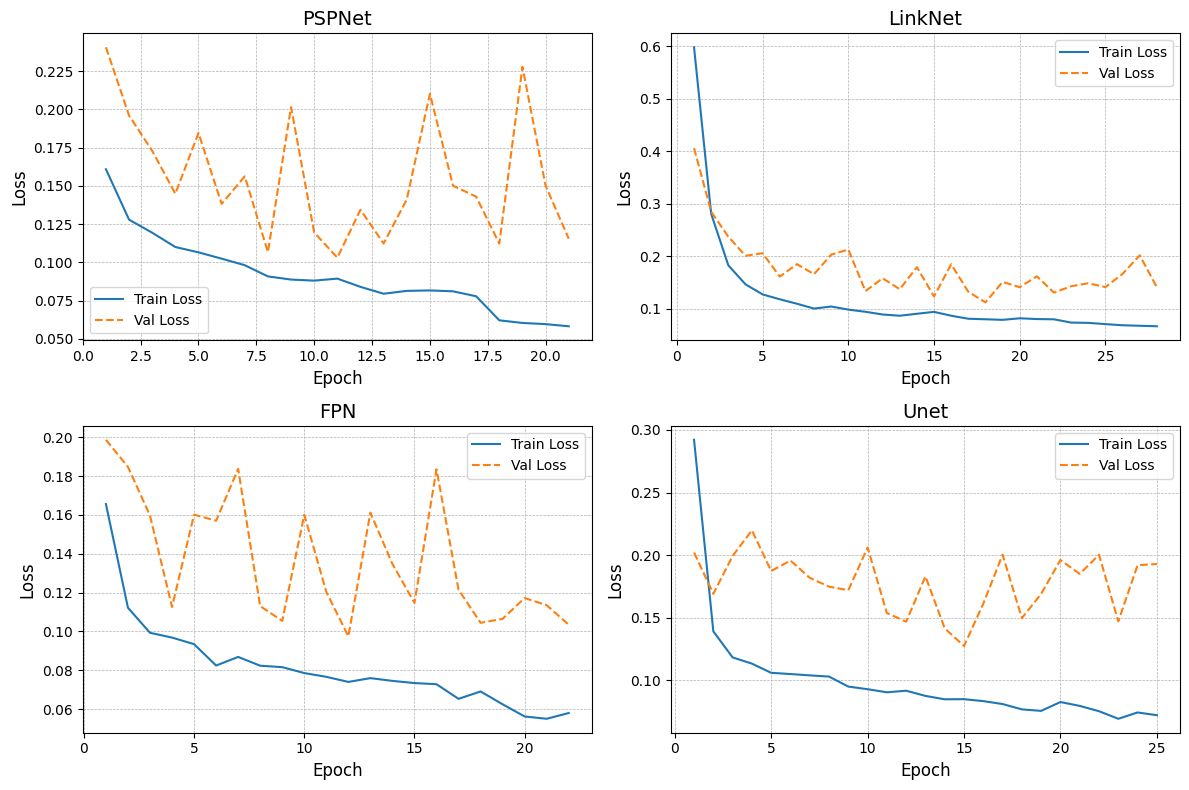

In [19]:
import json

history_path = os.path.join(path_model, "models", "loss_history.json")
with open(history_path, "r") as f:
    loss_history = json.load(f)

# Determine the grid size for the subplots.
n_models = len(loss_history)
n_cols = 2  # Set the desired number of columns
n_rows = math.ceil(n_models / n_cols)

epochs = range(1, NUM_EPOCHS + 1)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8))
# If there is only one row, axs might be 1D, so we flatten for consistency:
axs = axs.flatten() if n_models > 1 else [axs]

for i, (key, history) in enumerate(loss_history.items()):
    # Use the actual length of the training history for x-axis values.
    n_epochs = len(history["train"])
    epochs = range(1, n_epochs + 1)
    axs[i].plot(epochs, history["train"], label="Train Loss")
    axs[i].plot(epochs, history["val"], label="Val Loss", linestyle="--")
    axs[i].set_title(key, fontsize=14)
    axs[i].set_xlabel("Epoch", fontsize=12)
    axs[i].set_ylabel("Loss", fontsize=12)
    axs[i].grid(True, which="both", linestyle="--", linewidth=0.5)
    axs[i].legend(fontsize=10)

# Hide any unused subplots if n_models < n_rows*n_cols
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [20]:
criterion = torch.nn.CrossEntropyLoss()

def test_model(model, test_loader, criterion, device, num_classes=3):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
      for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        # Save predictions and targets for metric calculations
        all_preds.append(outputs.cpu())
        all_targets.append(masks.cpu())

    avg_loss = total_loss / len(test_loader)

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Evaluate using your multi-class evaluation function.
    metrics = eval_multi_class(all_preds, all_targets, num_classes=num_classes)

    print(f"Test Loss: {avg_loss:.4f}")
    print("Metrics:")
    print(f"  Mean IOU: {metrics['IOU']:.4f}")
    print(f"  Mean Precision: {metrics['Precision']:.4f}")
    print(f"  Mean Recall: {metrics['Recall']:.4f}")
    for i, (iou, prec, rec) in enumerate(zip(metrics["Class-wise IOU"], metrics["Class-wise Precision"], metrics["Class-wise Recall"])):
        print(f"  Class {i}: IOU: {iou:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    return metrics


# Helper function to calculate model size in number of parameters
def get_model_size(model):
    return sum(p.numel() for p in model.parameters())

# Evaluate models on test data and measure inference time
all_metrics = {}
all_model_sizes = {}
for key, cfg in models.items():
    model = cfg["model"]
    # Load best model weights and move to device
    state_dict = torch.load(os.path.join(path_model, "models", key, "best_model.pth"), map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    # Measure inference time
    start_time = time.time()
    print(f"Model: {key}")
    metrics = test_model(model, test_loader, criterion, device, num_classes=3)
    end_time = time.time()

    elapsed = end_time - start_time
    num_samples = len(test_loader.dataset)
    fps = num_samples / elapsed if elapsed > 0 else 0

    # Store metrics plus FPS
    metrics["FPS"] = fps
    all_metrics[key] = metrics

    # Compute and store model size (in millions)
    size = get_model_size(model) / 1e6  # convert to millions
    all_model_sizes[key] = size

print("Metrics collected:")
for m_name, m_vals in all_metrics.items():
    print(m_name, m_vals)
print("Model sizes (M parameters):", all_model_sizes)

# Prepare data for plotting
model_names = list(all_metrics.keys())
ious = [all_metrics[m]["IOU"] for m in model_names]
precisions = [all_metrics[m]["Precision"] for m in model_names]
recalls = [all_metrics[m]["Recall"] for m in model_names]
fpss = [all_metrics[m]["FPS"] for m in model_names]
model_sizes = [all_model_sizes[m] for m in model_names]

x = np.arange(len(model_names))  # x-axis positions for the bars

<ipython-input-20-45ec9c56aa20>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path_model, "models", key, "best_model.pth"), map_loca

Model: PSPNet
Test Loss: 16.3119
Metrics:
  Mean IOU: 0.2777
  Mean Precision: 0.8491
  Mean Recall: 0.3334
  Class 0: IOU: 0.8329, Precision: 0.8329, Recall: 1.0000
  Class 1: IOU: 0.0000, Precision: 1.0000, Recall: 0.0000
  Class 2: IOU: 0.0002, Precision: 0.7145, Recall: 0.0002
Model: LinkNet
Test Loss: 3.8806
Metrics:
  Mean IOU: 0.3296
  Mean Precision: 0.4646
  Mean Recall: 0.3829
  Class 0: IOU: 0.8418, Precision: 0.8562, Recall: 0.9804
  Class 1: IOU: 0.0002, Precision: 0.0030, Recall: 0.0002
  Class 2: IOU: 0.1468, Precision: 0.5347, Recall: 0.1683
Model: FPN
Test Loss: 0.5659
Metrics:
  Mean IOU: 0.3213
  Mean Precision: 0.8265
  Mean Recall: 0.3730
  Class 0: IOU: 0.8470, Precision: 0.8517, Recall: 0.9935
  Class 1: IOU: 0.0000, Precision: 1.0000, Recall: 0.0000
  Class 2: IOU: 0.1169, Precision: 0.6279, Recall: 0.1256
Model: Unet
Test Loss: 4.6869
Metrics:
  Mean IOU: 0.2847
  Mean Precision: 0.4159
  Mean Recall: 0.3391
  Class 0: IOU: 0.8347, Precision: 0.8365, Recall: 0.

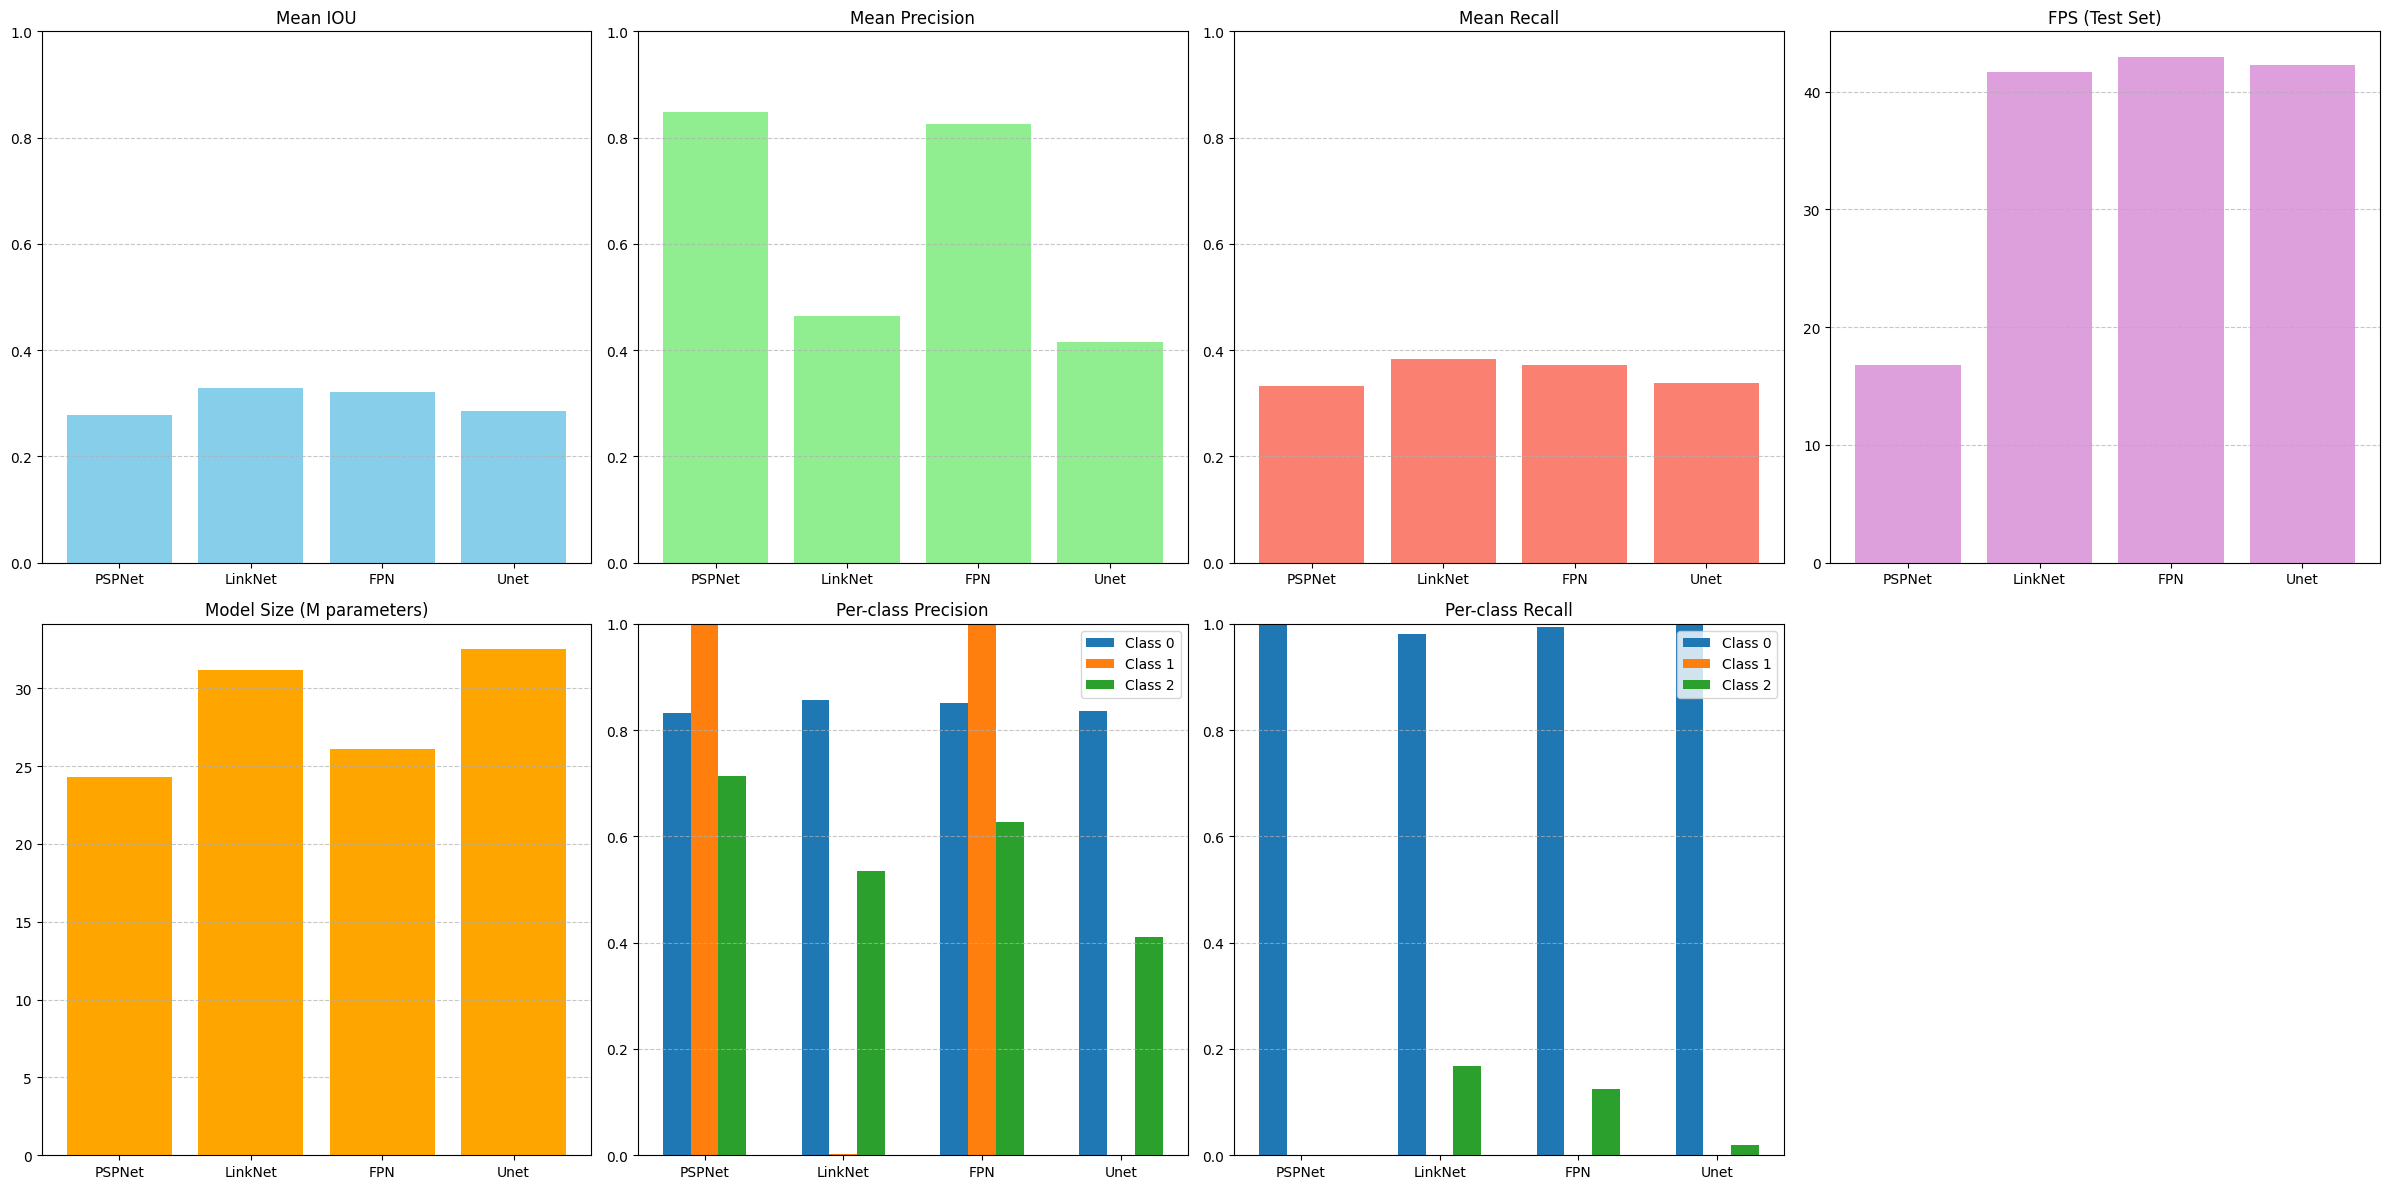

In [22]:
# Prepare data for plotting (mean metrics)
model_names = list(all_metrics.keys())
ious = [all_metrics[m]["IOU"] for m in model_names]
precisions = [all_metrics[m]["Precision"] for m in model_names]
recalls = [all_metrics[m]["Recall"] for m in model_names]
fpss = [all_metrics[m]["FPS"] for m in model_names]
model_sizes = [all_model_sizes[m] for m in model_names]

# Prepare data for per-class precision and recall
# Assume num_classes = 3
num_classes = 3
# Create lists of lists: one inner list per class containing values for each model.
class_precisions = [[] for _ in range(num_classes)]
class_recalls = [[] for _ in range(num_classes)]

for m in model_names:
    for cls in range(num_classes):
        class_precisions[cls].append(all_metrics[m]["Class-wise Precision"][cls])
        class_recalls[cls].append(all_metrics[m]["Class-wise Recall"][cls])

x = np.arange(len(model_names))  # positions for the models
bar_width = 0.2  # width for each bar in grouped bar charts

# Create a figure with 2 rows x 4 columns (8 subplots)
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

# Plot Mean IOU
axes[0].bar(x, ious, color="skyblue")
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names)
axes[0].set_title("Mean IOU")
axes[0].set_ylim([0, 1])
axes[0].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot Mean Precision
axes[1].bar(x, precisions, color="lightgreen")
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names)
axes[1].set_title("Mean Precision")
axes[1].set_ylim([0, 1])
axes[1].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot Mean Recall
axes[2].bar(x, recalls, color="salmon")
axes[2].set_xticks(x)
axes[2].set_xticklabels(model_names)
axes[2].set_title("Mean Recall")
axes[2].set_ylim([0, 1])
axes[2].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot FPS (inference speed)
axes[3].bar(x, fpss, color="plum")
axes[3].set_xticks(x)
axes[3].set_xticklabels(model_names)
axes[3].set_title("FPS (Test Set)")
axes[3].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot Model Size (in millions of parameters)
axes[4].bar(x, model_sizes, color="orange")
axes[4].set_xticks(x)
axes[4].set_xticklabels(model_names)
axes[4].set_title("Model Size (M parameters)")
axes[4].grid(True, axis="y", linestyle="--", alpha=0.7)

# Plot per-class Precision (grouped bar chart)
for cls in range(num_classes):
    # Offset each class' bars
    axes[5].bar(x + cls * bar_width, class_precisions[cls], width=bar_width, label=f"Class {cls}")
axes[5].set_xticks(x + bar_width)
axes[5].set_xticklabels(model_names)
axes[5].set_title("Per-class Precision")
axes[5].set_ylim([0, 1])
axes[5].grid(True, axis="y", linestyle="--", alpha=0.7)
axes[5].legend()

# Plot per-class Recall (grouped bar chart)
for cls in range(num_classes):
    axes[6].bar(x + cls * bar_width, class_recalls[cls], width=bar_width, label=f"Class {cls}")
axes[6].set_xticks(x + bar_width)
axes[6].set_xticklabels(model_names)
axes[6].set_title("Per-class Recall")
axes[6].set_ylim([0, 1])
axes[6].grid(True, axis="y", linestyle="--", alpha=0.7)
axes[6].legend()

# Leave the 8th subplot (axes[7]) empty or add another metric if desired.
axes[7].axis('off')

plt.tight_layout()
plt.show()


In [23]:
"""
Unfortunately I could not find any good candidate for the classification.
Decided to use FPN since it could somehow classify part of the classes
"""
# Based on the result FPN seems to have the best performance

MODEL = "FPN"
cfg = models[MODEL]
model = cfg["model"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(os.path.join(path_model,
                                     "models",
                                     MODEL,
                                     "best_model.pth"),
                                     map_location=device)
model.load_state_dict(state_dict)
model.to(device)

<ipython-input-23-6c82048ab853>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path_model,


FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

### Test the model on test dataset

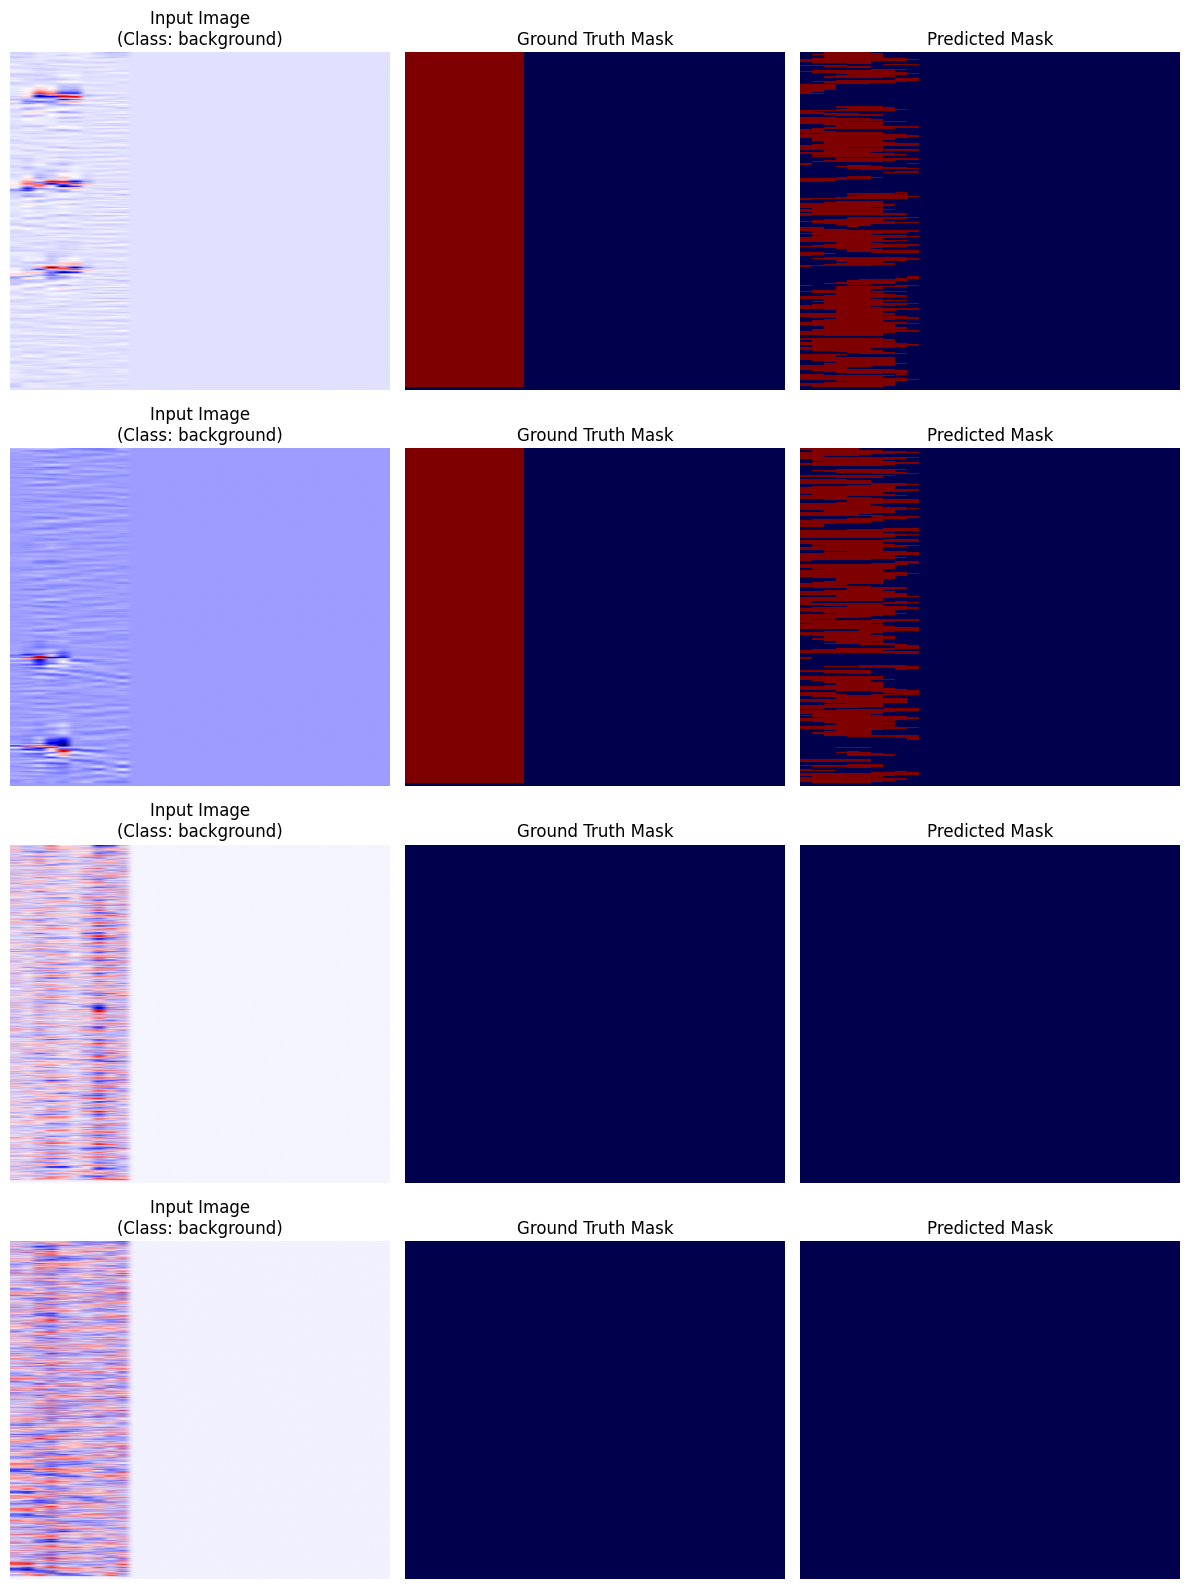

In [31]:
def get_majority_class(mask):
    """
    Return the label (as a string) corresponding to the majority class in mask.
    At the moment every image for test, train and validation has only one class
    Assumes mask has discrete integer values.
    """
    # Flatten the mask and count occurrences.
    counts = np.bincount(mask.flatten())
    # Majority label is the index with the maximum count.
    majority = np.argmax(counts)
    # Find the corresponding key in CLASS_ID
    key = next((k for k, v in CLASS_ID.items() if v == majority), str(majority))
    return key

def plot_random_model_outputs(model, dataset, device, num_images=4):
    """
    Randomly samples `num_images` from the dataset and plots:
      - The input image
      - The ground truth mask (with a label indicating the majority class)
      - The model prediction
    All plots are arranged in rows (one row per sample) with 3 columns.
    """
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    images_list = []
    masks_list = []
    for idx in indices:
        image, mask = dataset[idx]
        images_list.append(image)
        masks_list.append(mask)

    # Stack images and masks to form a batch
    images_batch = torch.stack(images_list).to(device)  # shape: [B, 1, H, W]
    # Get predictions
    with torch.no_grad():
        outputs = model(images_batch)  # Expected shape: [B, classes, H, W]
        preds = torch.argmax(outputs, dim=1)  # shape: [B, H, W]

    images_np = images_batch.cpu().numpy()  # [B, 1, H, W]
    masks_np = torch.stack(masks_list).numpy()  # [B, H, W]
    preds_np = preds.cpu().numpy()  # [B, H, W]

    # Set up the plot grid: one row per image, three columns.
    fig, axs = plt.subplots(num_images, 3, figsize=(12, 4*num_images))

    # If only one image, make axs iterable
    if num_images == 1:
        axs = [axs]

    cmap = "seismic"

    for i in range(num_images):
        # For the input image, if grayscale, display first channel.
        input_img = images_np[i, 0, :, :]
        majority_label = get_majority_class(masks_np[i])

        axs[i][0].imshow(input_img, cmap=cmap, aspect="auto")
        axs[i][0].set_title(f"Input Image\n(Class: {majority_label})", fontsize=12)
        axs[i][0].axis("off")

        # Ground truth mask
        axs[i][1].imshow(masks_np[i], cmap=cmap, interpolation="nearest", aspect="auto")
        axs[i][1].set_title("Ground Truth Mask", fontsize=12)
        axs[i][1].axis("off")

        # Predicted mask
        axs[i][2].imshow(preds_np[i], cmap=cmap, interpolation="nearest", aspect="auto")
        axs[i][2].set_title("Predicted Mask", fontsize=12)
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.show()

plot_random_model_outputs(model, test_dataset, device, num_images=4)



#Task 2: Inference

Reading the images at once will not fit the GPU. Thefore we will slice the image and allow a certain overlap when we slide the window


In [25]:
class Prototype:
  def __init__(self, model, model_path, device="cuda", patch_size=(1024, 896), overlap=0.2):
    self.model_path = model_path
    self.device = device
    self.patch_size = patch_size
    self.overlap = overlap

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    self.model = model.to(device)
    self.model.eval()

  @staticmethod
  def read_image(path):
    """
    Reads an image from disk, filters it, and returns a contiguous NumPy array.
    """
    data = np.load(path)
    data = np.cumsum(data, axis=0, dtype=np.int64).astype(np.float32)
    data *= np.pi / 2**15  # Convert to radians

    from scipy import signal
    sos = signal.butter(2, 5, "high", fs=1000, output="sos")
    data = signal.sosfiltfilt(sos, data, axis=0)
    return np.ascontiguousarray(data)

  def run(self, image):
      """
      Performs sliding window inference on a large input image tensor.

      Parameters:
        image: np image of shape [H, W]

      Returns:
        final_prediction: torch.Tensor of shape [H, W] (with predicted class indices)
      """
      image =  torch.from_numpy(image)  # shape: [H, W]
      # If the image is 2D (grayscale), add a channel dimension.
      if image.dim() == 2:
        image = image.unsqueeze(0)  # Now shape becomes [1, H, W]

      # Add the batch dimension: [B, C, H, W]
      input_tensor = image.unsqueeze(0).float()  # shape: [1, 1, H, W]

      # For sliding window inference, move to CPU first (patches will be moved to device as needed)
      image_tensor = input_tensor.cpu()

      C, H, W = image_tensor.shape[1:]
      patch_h, patch_w = self.patch_size

      # Compute strides based on overlap
      stride_h = int(patch_h * (1 - self.overlap))
      stride_w = int(patch_w * (1 - self.overlap))

      # Create tensors to accumulate predictions and counts for overlapping regions.
      full_prediction = torch.zeros((H, W), dtype=torch.float32, device=self.device)
      count_map = torch.zeros((H, W), dtype=torch.float32, device=self.device)

      # Iterate over the image with the sliding window.
      for top in range(0, H - patch_h + 1, stride_h):
          for left in range(0, W - patch_w + 1, stride_w):
              # Extract patch of shape [C, patch_h, patch_w]
              patch = image_tensor[0, :, top:top+patch_h, left:left+patch_w]
              patch = patch.unsqueeze(0).to(self.device)  # shape: [1, C, patch_h, patch_w]

              with torch.no_grad():
                  output = self.model(patch)  # Expected shape: [1, num_classes, patch_h, patch_w]
                  pred_patch = torch.argmax(output, dim=1)  # shape: [1, patch_h, patch_w]

              pred_patch = pred_patch[0].float()
              full_prediction[top:top+patch_h, left:left+patch_w] += pred_patch
              count_map[top:top+patch_h, left:left+patch_w] += 1.0

      # Avoid division by zero
      count_map[count_map == 0] = 1.0
      averaged_prediction = full_prediction / count_map
      final_prediction = torch.round(averaged_prediction).to(torch.long)
      return final_prediction



if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


# Set desired patch size and overlap for inference.
cable_length = 896 # image width this is expected to be constant since its the fiber optics physical length
patch_size = (1024, cable_length)  # Adjust based on available memory and desired patch size.
overlap = 0.2  # 20% overlap
model_path = os.path.join(path_model, "models", MODEL, "best_model.pth")

prototype = Prototype(model, model_path, device, patch_size, overlap)
inf_img = glob.glob( os.path.join(path_task2, 'inference', '*.npy'), recursive=True)

inference_image = prototype.read_image(inf_img[0])
predicted_mask = prototype.run(inference_image)
predicted_mask = predicted_mask.cpu().numpy()


Using device: cuda


<ipython-input-25-927c86502fd7>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


### Display the the inference

<ipython-input-26-e1c504e98e8a>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


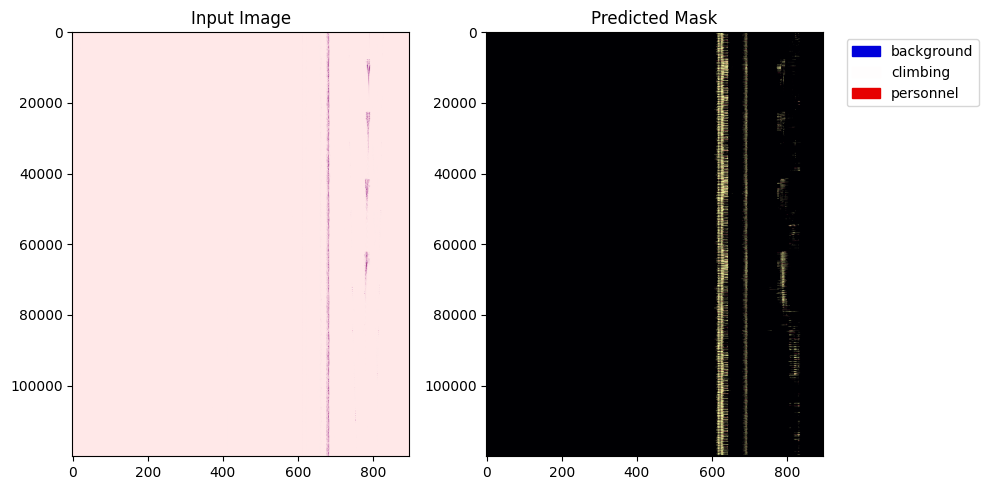

In [26]:
# Define your colormap and class mapping

class_labels = {0: "Background", 1: "Climbing", 2: "Personnel"}

# Get the colormap object
colormap = plt.cm.get_cmap(cmap)

# Choose representative colors for each class.
# Adjust the values (0-1) as needed to get distinct colors.
colors = {
    0: colormap(0.2),  # Background
    1: colormap(0.5),  # Climbing
    2: colormap(0.8)   # Personnel
}

# Create legend handles for each class.
patches = [mpatches.Patch(color=colors[CLASS_ID[key]], label=key) for key in CLASS_ID]


# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(inference_image, cmap="seismic", aspect="auto")
plt.title("Input Image")
#plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="inferno", aspect="auto")
plt.title("Predicted Mask")
#plt.axis("off")

# Add the legend outside the plot (for the predicted mask)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


 A standalone python script is created which reads the image and outputs the mask and display the result to call the script:
 (currently only works with FPN weights)

 ```bash
python prototype_inference.py \
  --inference_image "/path/to/inference.npy" \
  --model_path "/path/to/best_model.pth" \
  --output_figure "output_figure.png" \
  --save_mask \
  --save_mask_path "predicted_mask.npy" \
  --dilate_mask \
  --dilation_kernel_size "5,5" \
  --dilation_iterations 1 \
  --debug





#Task 4: Testing new sample

In [27]:
################################################################################
# collect all training data
################################################################################
bg_path, bg_id = gather_class_paths(task_dir=path_task4, split="training",
                                    class_name="background",
                                    class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="training",
                                      class_name="personnel",
                                      class_id=CLASS_ID["personnel"])

all_training_path = bg_path + prs_path
all_training_id = bg_id + prs_id + clm_id

train_dataset = SegmentationDataset(
    image_path=all_training_path,
    class_id=all_training_id,
    transform=True
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


################################################################################
# collect all validation & test data (20% goes to test dataset)
################################################################################
bg_path, bg_id = gather_class_paths(task_dir=path_task1, split="validation",
                                    class_name="background",
                                    class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="validation",
                                      class_name="personnel",
                                      class_id=CLASS_ID["personnel"])

all_paths = bg_path + prs_path
all_ids = bg_id + prs_id

val_paths, test_paths, val_ids, test_ids = train_test_split(
    all_paths, all_ids, test_size=0.2, random_state=42, stratify=all_ids
)


val_dataset = SegmentationDataset(
    image_path=val_paths,
    class_id=val_ids,
    transform=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_dataset = SegmentationDataset(
    image_path=test_paths,
    class_id=test_ids,
    transform=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


print(f"Number of training dataset: {len(train_dataset)}")
print(f"Number of validation dataset: {len(val_dataset)}")
print(f"Number of test dataset: {len(test_dataset)}")


Number of training dataset: 2001
Number of validation dataset: 1396
Number of test dataset: 349


In [30]:
# Fine-Tuning

NUM_EPOCHS = 50
MODEL = "FPN"
cfg = models[MODEL]
model = cfg["model"]
state_dict = torch.load(os.path.join(path_model,
                                     "models",
                                     MODEL,
                                     "best_model.pth"),
                                     map_location=device)
model.load_state_dict(state_dict)

# Use CrossEntropyLoss for multi-class classification
# ignore climbing class since we dont have the dataset for fine-tuning
criterion = torch.nn.CrossEntropyLoss(ignore_index=1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define optimizer
# keep low lr with a weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
# allow lr to change if model is not improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=5,
    verbose=True
)

best_val_loss = float('inf')
train_loss_history = []
val_loss_history = []

# Define model saving directory
model_dir = os.path.join(path_model, "fine-tuned", MODEL)
os.makedirs(model_dir, exist_ok=True)

model.to(device)

for epoch in range(NUM_EPOCHS):
  start_time = time.time()
  # Train and evaluate the model
  train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
  val_loss = evaluate(model, val_loader, criterion, device)
  scheduler.step(val_loss) # adapt lr based on changes in the val_loss

  epoch_time = time.time() - start_time

  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)

  # Save the best model based on validation loss
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), os.path.join(model_dir, 'best_model_tuned.pth'))
      print(f"New best model {MODEL} saved at epoch {epoch+1}, Val Loss: {val_loss:.4f}")

  print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Duration: {epoch_time:.2f} sec, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

loss_history[MODEL] = {"train": train_loss_history, "val": val_loss_history}



<ipython-input-30-394dc1e92f55>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path_model,


Using device: cuda
New best model FPN saved at epoch 1, Val Loss: 0.3126
Epoch 1/50 - Duration: 22.64 sec, Train Loss: 0.0107, Val Loss: 0.3126
Epoch 2/50 - Duration: 21.83 sec, Train Loss: 0.0065, Val Loss: 0.3494
New best model FPN saved at epoch 3, Val Loss: 0.2772
Epoch 3/50 - Duration: 21.96 sec, Train Loss: 0.0051, Val Loss: 0.2772
Epoch 4/50 - Duration: 22.29 sec, Train Loss: 0.0045, Val Loss: 0.3604
Epoch 5/50 - Duration: 21.89 sec, Train Loss: 0.0039, Val Loss: 0.4912
Epoch 6/50 - Duration: 22.60 sec, Train Loss: 0.0058, Val Loss: 0.3556
Epoch 7/50 - Duration: 22.11 sec, Train Loss: 0.0061, Val Loss: 0.3018
New best model FPN saved at epoch 8, Val Loss: 0.2629
Epoch 8/50 - Duration: 21.65 sec, Train Loss: 0.0048, Val Loss: 0.2629
Epoch 9/50 - Duration: 22.68 sec, Train Loss: 0.0028, Val Loss: 0.4217
Epoch 10/50 - Duration: 22.02 sec, Train Loss: 0.0040, Val Loss: 0.3475
Epoch 11/50 - Duration: 21.98 sec, Train Loss: 0.0046, Val Loss: 0.3509
Epoch 12/50 - Duration: 22.42 sec, T